In [574]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of the dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [575]:
# This version of the function returns a dict of stats we can use to compare various models' performance,
#  if five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print(ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [576]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

# We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Setting the alpha low helps us understand whether there is a concentration of observations
#  at a particular point, or if it is an outlier
    ax = sns.regplot(y_test,y_preds_test,scatter_kws={'alpha':0.3})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

In [577]:
def lookup_gdp(month,year):
    if month in [1,2,3]:
        retmo = 1
    elif month in [4,5,6]:
        retmo = 4
    elif month in [7,8,9]:
        retmo = 7
    else:
        retmo=10
    datestr = "{}-{:02d}-01".format(year,retmo)
    return(int(gdp_df.loc[gdp_df['DATE'] == datestr]['GDP'].values[0]))

In [578]:
def lookup_int_rate(month,year):
    datestr = "{}-{:02d}-01".format(year,month)
    return(int_rate_df.loc[int_rate_df['DATE'] == datestr]['FEDFUNDS'].values[0])

In [579]:
def set_taxcred(year_sold):
    if 2008 <= year_sold <= 2010:
# Remember, these values need to be numerical...I had True/False here and then thought better of it.
        return 1
    else:
        return 0

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

# 1. Load the houseprices data from Thinkful's database.

In [580]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# 2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [581]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [582]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

In [583]:
# Remove a handful of huge outliers from the dataset before we begin training.
# I learned this technique from the Udemy course I've also been working through.
q = house_df['saleprice'].quantile(.99)
house_df = house_df[house_df['saleprice'] < q]

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

In [584]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])
house_df = house_df.drop(columns=['lotarea'])

__I want to try some things:__
1. Stick with my current approach of creating a second dataframe of hand-picked variables
2. Create a dataframe that has all of the dummy variables for categorical data, and the continuous variables, and let a model (Lasso and/or ElasticNet?) pick the best variables for me. 
3. Create a copy of the dataframe in #2 that is regularized/scaled.

The following cells create the dataframes I describe in #2 and #3. My original work is below that.

In [585]:
for categorical in house_df.describe(exclude=np.number).columns:
    house_df = pd.concat([house_df, pd.get_dummies(house_df[categorical],drop_first=True,prefix=categorical)], axis=1)

In [586]:
# This grabs just the continuous variables from our dataset.
all_house_df = house_df[house_df.describe(include=np.number).columns]

# Then, concatenate dummy versions of the categorical variables.
# We do this column by column because trying to do it all in one shot introduced 
# a lot of duplicate columns with NaNs in them.
for column in house_df.describe(exclude=np.number).columns:
    all_house_df = pd.concat([all_house_df,pd.get_dummies(house_df[column],drop_first=True,prefix=column)],axis=1)
all_house_df.head()

,mssubclass,lotfrontage,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,log_lotarea,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_NA,masvnrtype_None,masvnrtype_Stone,exterqual_Fa,exterqual_Gd,exterqual_TA,extercond_Fa,extercond_Gd,extercond_Po,extercond_TA,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_NA,bsmtqual_TA,bsmtcond_Gd,bsmtcond_NA,bsmtcond_Po,bsmtcond_TA,bsmtexposure_Gd,bsmtexposure_Mn,bsmtexposure_NA,bsmtexposure_No,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_NA,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_NA,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heatingqc_Fa,heatingqc_Gd,heatingqc_Po,heatingqc_TA,centralair_Y,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_NA,fireplacequ_Po,fireplacequ_TA,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_NA,garageyrblt_1906.0,garageyrblt_1908.0,garageyrblt_1910.0,garageyrblt_1914.0,garageyrblt_1915.0,garageyrblt_1916.0,garageyrblt_1918.0,garageyrblt_1920.0,garageyrblt_1921.0,garageyrblt_1922.0,garageyrblt_1923.0,garageyrblt_1924.0,garageyrblt_1925.0,garageyrblt_1926.0,garageyrblt_1927.0,garageyrblt_1928.0,garageyrblt_1929.0,garageyrblt_1930.0,garageyrblt_1931.0,garageyrblt_1932.0,garageyrblt_1933.0,garageyrblt_1934.0,garageyrblt_1935.0,garageyrblt_1936.0,garageyrblt_1937.0,garageyrblt_1938.0,garageyrblt_1939.0,garageyrblt_1940.0,garageyrblt_1941.0,garageyrblt_1942.0,garageyrblt_1945.0,garageyrbl

In [587]:
all_house_df['log_saleprice'] = np.log(all_house_df['saleprice'])
all_house_df = all_house_df.drop(columns=['saleprice'])

In [588]:
# Scale the features so we can more easily determine which are the most significant
scaler = StandardScaler()
scaled_all_house_arr = scaler.fit_transform(all_house_df)

In [589]:
scaled_all_house_df = pd.DataFrame(scaled_all_house_arr,columns=all_house_df.columns)

In [590]:
scaled_all_house_df.describe()

,mssubclass,lotfrontage,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,log_lotarea,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_NA,masvnrtype_None,masvnrtype_Stone,exterqual_Fa,exterqual_Gd,exterqual_TA,extercond_Fa,extercond_Gd,extercond_Po,extercond_TA,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_NA,bsmtqual_TA,bsmtcond_Gd,bsmtcond_NA,bsmtcond_Po,bsmtcond_TA,bsmtexposure_Gd,bsmtexposure_Mn,bsmtexposure_NA,bsmtexposure_No,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_NA,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_NA,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heatingqc_Fa,heatingqc_Gd,heatingqc_Po,heatingqc_TA,centralair_Y,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_NA,fireplacequ_Po,fireplacequ_TA,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_NA,garageyrblt_1906.0,garageyrblt_1908.0,garageyrblt_1910.0,garageyrblt_1914.0,garageyrblt_1915.0,garageyrblt_1916.0,garageyrblt_1918.0,garageyrblt_1920.0,garageyrblt_1921.0,garageyrblt_1922.0,garageyrblt_1923.0,garageyrblt_1924.0,garageyrblt_1925.0,garageyrblt_1926.0,garageyrblt_1927.0,garageyrblt_1928.0,garageyrblt_1929.0,garageyrblt_1930.0,garageyrblt_1931.0,garageyrblt_1932.0,garageyrblt_1933.0,garageyrblt_1934.0,garageyrblt_1935.0,garageyrblt_1936.0,garageyrblt_1937.0,garageyrblt_1938.0,garageyrblt_1939.0,garageyrblt_1940.0,garageyrblt_1941.0,garageyrblt_1942.0,garageyrblt_1945.0,garageyrblt_1946.0,g

Here's my original work to create some features I thought may be interesting. None of them turn out to be significant enough to stick around in the model, which I learned by looking at the heatmap (easy way to visualize the correlation matrix).

In [591]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})
house_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))
house_df['has_paveddrive'] = (house_df['paveddrive'].map({'Y': 1, 'N': 0, 'P': 0}))
house_df['has_gasheat'] = (house_df['heating'].map({'GasA': 1, 'GasW': 1, 'Grav': 0,
                                                    'Wall': 0, 'OthW': 0, 'Floor': 0}))
house_df['has_fingarage'] = (house_df['garagefinish'].map({'Fin': 1, 'RFn': 1, 'Unf': 0,'NA': 0}))

In [592]:
overall_correlation = house_df.corr()

In [593]:
correlated_columns = overall_correlation['saleprice'].sort_values(ascending=False).head(20).index

In [594]:
corr_col_corr = house_df[correlated_columns].corr()

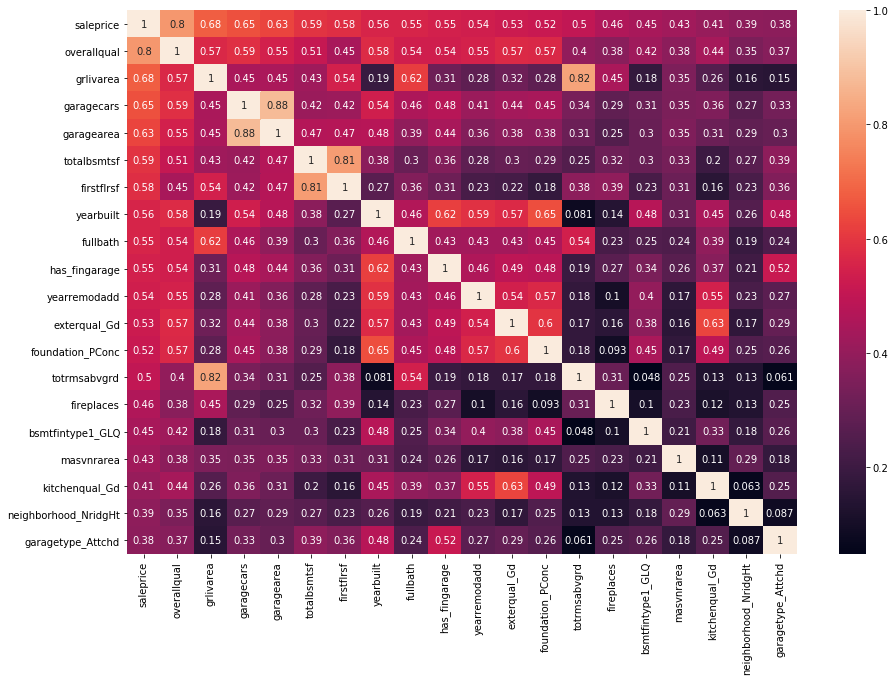

In [595]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(corr_col_corr,annot=True)

In [596]:
# Start with these features of interest. 
vars_of_interest = ['grlivarea', 'garagecars', 'totalbsmtsf', 'yearbuilt',
                    'exterqual_Gd', 'fireplaces', 'bsmtfintype1_GLQ', 
                    'log_lotarea', 'neighborhood_NridgHt',
                   ]

import copy
int_plus_saleprice = copy.deepcopy(vars_of_interest)
int_plus_saleprice.append('saleprice')

# Create a copy of the dataframe that's just these variables--it'll be easier to manage/manipulate
house_interest_df = house_df[int_plus_saleprice]
house_interest_df.head()

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
0,1710,2,856,2003,1,0,1,9.041922,0,208500
1,1262,2,1262,1976,0,1,0,9.169518,0,181500
2,1786,2,920,2001,1,1,1,9.328123,0,223500
3,1717,3,756,1915,0,1,0,9.164296,0,140000
4,2198,3,1145,2000,1,1,1,9.565214,0,250000


In [597]:
house_interest_df.describe(include='all')

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
count,1445.000000,1445.000000,1445.00000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000
mean,1500.154325,1.754325,1047.15917,1971.004844,0.334948,0.604152,0.281661,9.103920,0.048443,177082.510035
std,500.813151,0.740492,426.37156,30.109369,0.472136,0.640061,0.449965,0.513978,0.214775,69614.603756
min,334.000000,0.000000,0.00000,1872.000000,0.000000,0.000000,0.000000,7.170120,0.000000,34900.000000
25%,1126.000000,1.000000,794.00000,1954.000000,0.000000,0.000000,0.000000,8.922658,0.000000,129900.000000
50%,1456.000000,2.000000,988.00000,1972.000000,0.000000,1.000000,0.000000,9.151651,0.000000,162000.000000
75%,1768.000000,2.000000,1278.00000,2000.000000,1.000000,1.000000,1.000000,9.348187,0.000000,212000.000000
max,5642.000000,4.000000,6110.00000,2010.000000,1.000000,3.000000,1.000000,12.279532,1.000000,440000.000000


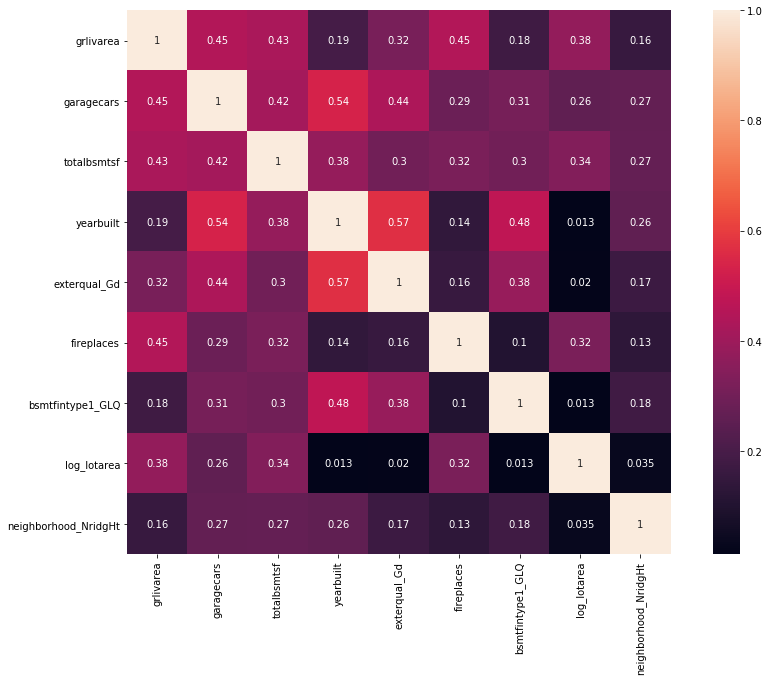

In [598]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(house_interest_df[vars_of_interest].corr(),annot=True,square=True)

# 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

__NOTE:__ Performing a log transformation on the dependent variable (home sale price) made its distribution much more normal, and made the model fit better. 

In the "all" and scaled datasets, I perform this log transformation and use that column instead. The original column is dropped to prevent multicollinearity issues.

In [599]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[vars_of_interest]

In [600]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


Copy of the dataset with all of the categorical variables blown out into dummy features:

In [601]:
# This is the version of the dataset that includes all categorical as well as continuous features 
X_all = all_house_df.drop(columns=['log_saleprice'])
Y_all = all_house_df['log_saleprice']

Xall_train, Xall_test, yall_train, yall_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xall_train.shape[0]))
print("The number of observations in test set is {}".format(Xall_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


Copy of the full dataset, but regularized using Scaler:

In [602]:
# How does it look if we use the scaled version of the "all" dataset instead?
X_scaled = scaled_all_house_df.drop(columns=['log_saleprice'])
Y_scaled = scaled_all_house_df['log_saleprice']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


# 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [603]:
# Capture k-fold output in a dataframe, so comparing performance will be easier
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

### Linear Regression

In [604]:
linear = LinearRegression()
cv_results = kfold_xval(linear,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.8020104366686538, 'Fold_2': 0.7925822826070211, 'Fold_3': 0.8293491701280619, 'Fold_4': 0.7026293062329904, 'Fold_5': 0.8515623676483204}


R-squared of the model on the training set is: 0.8064103635803673
-----Test set statistics-----
R-squared of the model on the test set is: 0.7127255405873931
Mean absolute error of the prediction is: 0.1249465026271885
Mean squared error of the prediction is: 0.045166332445008825
Root mean squared error of the prediction is: 0.21252372207593398
Mean absolute percentage error of the prediction is: 1.0410175148594554


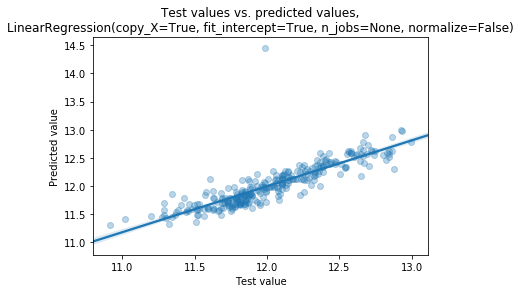

In [605]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

In [606]:
linear_all = LinearRegression()
cv_results = kfold_xval(linear_all,Xall_train,yall_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': -935370700536.6329, 'Fold_2': -11066549042119.598, 'Fold_3': -2931874172531.5156, 'Fold_4': -553868682375.5544, 'Fold_5': -6499864480905.207}


R-squared of the model on the training set is: 0.9467945507093954
-----Test set statistics-----
R-squared of the model on the test set is: -727183475.2112721
Mean absolute error of the prediction is: 1711.2949270306801
Mean squared error of the prediction is: 114330423.60338049
Root mean squared error of the prediction is: 10692.540558884053
Mean absolute percentage error of the prediction is: 14403.0643547879


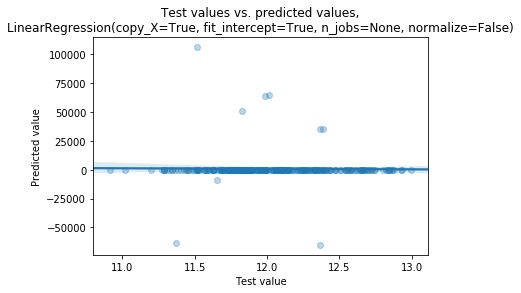

In [607]:
comp_train_test(linear_all,Xall_train,yall_train,Xall_test,yall_test)

In [608]:
linear_scl = LinearRegression()
cv_results = kfold_xval(linear_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': -1.71970365931541e+26, 'Fold_2': -1.6715169848933205e+25, 'Fold_3': -1.2483404099293889e+26, 'Fold_4': -9.58301240699723e+25, 'Fold_5': -2.8907091860814244e+24}


R-squared of the model on the training set is: 0.9462537046569457
-----Test set statistics-----
R-squared of the model on the test set is: -1.7307425193747946e+25
Mean absolute error of the prediction is: 588559740637.9957
Mean squared error of the prediction is: 1.8612343261438715e+25
Root mean squared error of the prediction is: 4314202505844.9346
Mean absolute percentage error of the prediction is: 437470789717205.5


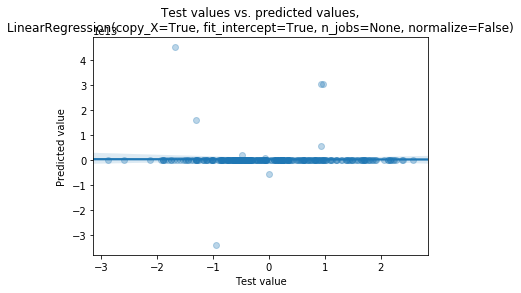

In [609]:
comp_train_test(linear_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

So clearly, feeding the basic linear regression model a large number of scaled features is not a good idea. The training scores are terrible, and the test measures for the scaled data are totally out of line. (Negative R^2 values!--which I understand means that [a horizontal line would describe the data better than this model](https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean/183279).)

### Ridge

In [610]:
ridge = Ridge()
cv_results = kfold_xval(ridge,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.8018604055127205, 'Fold_2': 0.7926650168305711, 'Fold_3': 0.8293914892765961, 'Fold_4': 0.702445249208284, 'Fold_5': 0.8517734325177087}


R-squared of the model on the training set is: 0.8064077759308848
-----Test set statistics-----
R-squared of the model on the test set is: 0.7124305731715002
Mean absolute error of the prediction is: 0.12485810389172007
Mean squared error of the prediction is: 0.045212708291973804
Root mean squared error of the prediction is: 0.21263280154288003
Mean absolute percentage error of the prediction is: 1.040294559486799


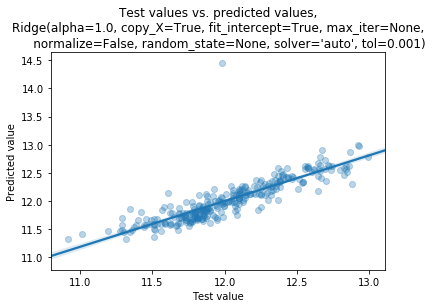

In [611]:
comp_train_test(ridge,X_train,y_train,X_test,y_test)

I'm curious about whether the Ridge model does a better job with scaled data.

In [612]:
ridge_scl = Ridge()
cv_results = kfold_xval(ridge_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.8567445000462972, 'Fold_2': 0.7852579491294714, 'Fold_3': 0.8569729188489137, 'Fold_4': 0.7560431004148087, 'Fold_5': 0.8726714879859809}


R-squared of the model on the training set is: 0.9467632317771452
-----Test set statistics-----
R-squared of the model on the test set is: 0.7397337467589853
Mean absolute error of the prediction is: 0.27486801445065556
Mean squared error of the prediction is: 0.2798893995185479
Root mean squared error of the prediction is: 0.5290457442589893
Mean absolute percentage error of the prediction is: 97.20258455270412


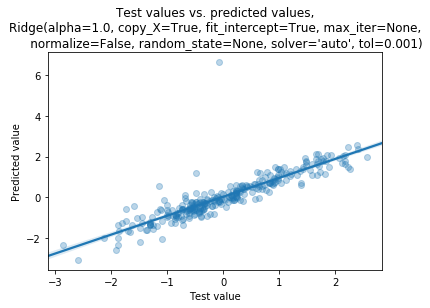

In [613]:
comp_train_test(ridge_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

...And it does perform slightly better!

### Lasso

In [614]:
lasso = Lasso()
cv_results = kfold_xval(lasso,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7388743556759736, 'Fold_2': 0.7243541801738779, 'Fold_3': 0.7544872204160755, 'Fold_4': 0.6093741598916742, 'Fold_5': 0.7970881828048506}


R-squared of the model on the training set is: 0.7364562607575793
-----Test set statistics-----
R-squared of the model on the test set is: 0.5600785356041682
Mean absolute error of the prediction is: 0.1465646546025085
Mean squared error of the prediction is: 0.06916604821474527
Root mean squared error of the prediction is: 0.2629943881810889
Mean absolute percentage error of the prediction is: 1.2185961407281498


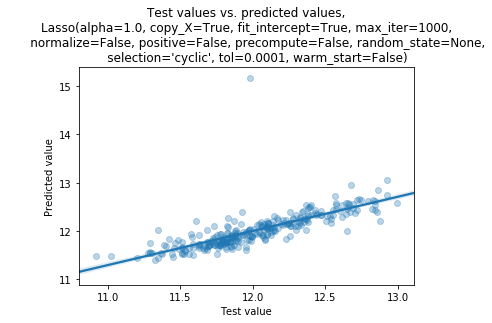

In [615]:
comp_train_test(lasso,X_train,y_train,X_test,y_test)

Here, we try training/testing with the full set of continous + dummy features available. Lasso should reduce most of the coefficients for these to zero, leaving only the significant features to influence the model.

In [616]:
lasso_all = Lasso()
cv_results = kfold_xval(lasso_all,Xall_train,yall_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.785141781991119, 'Fold_2': 0.7764956635856732, 'Fold_3': 0.7849975676993315, 'Fold_4': 0.6304027356913855, 'Fold_5': 0.8462017857183953}


R-squared of the model on the training set is: 0.7813659732112408
-----Test set statistics-----
R-squared of the model on the test set is: 0.5645544584078435
Mean absolute error of the prediction is: 0.13601743076519768
Mean squared error of the prediction is: 0.06846232739750883
Root mean squared error of the prediction is: 0.26165306686050677
Mean absolute percentage error of the prediction is: 1.1312116091810958


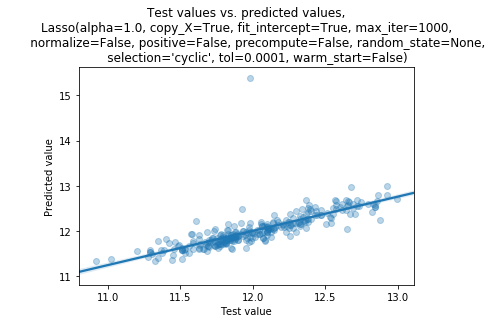

In [617]:
comp_train_test(lasso_all,Xall_train,yall_train,Xall_test,yall_test)

In [618]:
lasso_scl = Lasso()
cv_results = kfold_xval(lasso_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': -0.007619201264994269, 'Fold_2': -0.00029597765756750327, 'Fold_3': -9.988262697158136e-06, 'Fold_4': -0.01681576835288645, 'Fold_5': -0.0015350792040571548}


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0023606092899195463
Mean absolute error of the prediction is: 0.8399632330030592
Mean squared error of the prediction is: 1.0779350205476055
Root mean squared error of the prediction is: 1.0382364954804881
Mean absolute percentage error of the prediction is: 100.06523675840506


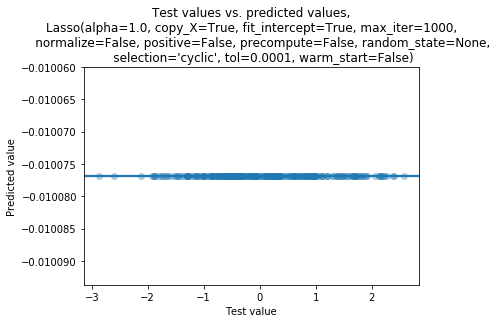

In [619]:
comp_train_test(lasso_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

### ElasticNet

Shifting the ratio to .01, favoring the Ridge penalty over the Lasso penalty, seems to yield good results.

In [620]:
elastic = ElasticNet(l1_ratio=.01)
cv_results = kfold_xval(elastic,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.753529902195073, 'Fold_2': 0.7451397816021542, 'Fold_3': 0.7825056029660835, 'Fold_4': 0.632099165448242, 'Fold_5': 0.8253264167689065}


R-squared of the model on the training set is: 0.7590354546742567
-----Test set statistics-----
R-squared of the model on the test set is: 0.6046083353385978
Mean absolute error of the prediction is: 0.13713190677971215
Mean squared error of the prediction is: 0.06216491159220203
Root mean squared error of the prediction is: 0.24932892249436692
Mean absolute percentage error of the prediction is: 1.1411005237279999


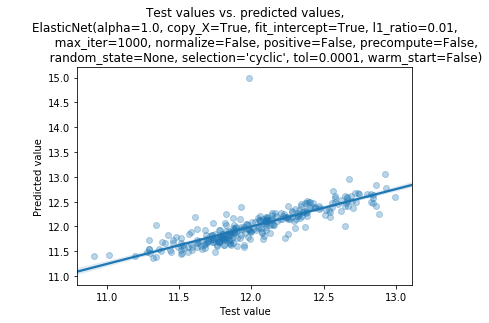

In [621]:
comp_train_test(elastic,X_train,y_train,X_test,y_test)

In [622]:
elastic_scl = ElasticNet(l1_ratio=.01)
cv_results = kfold_xval(elastic_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.8706537684335283, 'Fold_2': 0.8450297793321833, 'Fold_3': 0.8796023735018466, 'Fold_4': 0.8132178756037645, 'Fold_5': 0.8798898288937032}


R-squared of the model on the training set is: 0.8961267238108751
-----Test set statistics-----
R-squared of the model on the test set is: 0.8273518602127806
Mean absolute error of the prediction is: 0.25848818977557536
Mean squared error of the prediction is: 0.18566519312932628
Root mean squared error of the prediction is: 0.4308888408038972
Mean absolute percentage error of the prediction is: 90.96576481121006


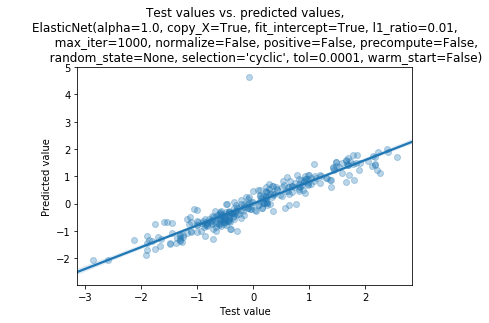

In [623]:
comp_train_test(elastic_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

## 5. Evaluate your best model on the test set.

### Comparing scores from cross-validation

In [624]:
kfold_df['avg_score'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_score'],ascending=False)

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_score
9,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",8.706538e-01,8.450298e-01,8.796024e-01,8.132179e-01,8.798898e-01,8.576787e-01
4,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",8.567445e-01,7.852579e-01,8.569729e-01,7.560431e-01,8.726715e-01,8.255380e-01
3,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",8.018604e-01,7.926650e-01,8.293915e-01,7.024452e-01,8.517734e-01,7.956271e-01
0,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",8.020104e-01,7.925823e-01,8.293492e-01,7.026293e-01,8.515624e-01,7.956267e-01
6,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",7.851418e-01,7.764957e-01,7.849976e-01,6.304027e-01,8.462018e-01,7.646479e-01
8,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",7.535299e-01,7.451398e-01,7.825056e-01,6.320992e-01,8.253264e-01,7.477202e-01
5,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",7.388744e-01,7.243542e-01,7.544872e-01,6.093742e-01,7.970882e-01,7.248356e-01
7,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",-7.619201e-03,-2.959777e-04,-9.988263e-06,-1.681577e-02,-1.535079e-03,-5.255203e-03
1,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",-9.353707e+11,-1.106655e+13,-2.931874e+12,-5.538687e+11,-6.499864e+12,-4.397505e+12
2,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",-1.719704e+26,-1.671517e+25,-1.248340e+26,-9.583012e+25,-2.890709e+24,-8.244808e+25


So the ElasticNet model, running against the "all" training dataset, gives the best average score using the training data.

### Comparing training vs. test output

The same ElasticNet model performed the best against the test dataset, with an $R^2$ value of 82.7%.

```
R-squared of the model on the training set is: 0.8961267238108751
-----Test set statistics-----
R-squared of the model on the test set is: 0.8273518602127806
Mean absolute error of the prediction is: 0.25848818977557536
Mean squared error of the prediction is: 0.18566519312932628
Root mean squared error of the prediction is: 0.4308888408038972
Mean absolute percentage error of the prediction is: 90.96576481121006
```

## 6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

I downloaded a CSV of quarterly real GDP per capita from the [Federal Reserve Bank of St. Louis' website](https://fred.stlouisfed.org/series/A939RX0Q048SBEA), covering the months/years sold dates in the dataset. I considered swapping this out for Iowa's GDP per capita, but those numbers rose and fell more or less in tandem with the national numbers.

I downloaded monthly federal interest rate data from [the same site](https://fred.stlouisfed.org/series/FEDFUNDS), also covering the relevant period of time for this dataset. Lower interest rates often spur home purchases.

### GDP per capita, by quarter

In [625]:
gdp_df = pd.read_csv('real_gdp_per_capita_2006_2010.csv')

In [626]:
gdp_df.rename(columns={"A939RX0Q048SBEA": "GDP"},inplace=True)

In [627]:
all_house_df['gdp'] = house_df.apply(lambda row: lookup_gdp(row['mosold'],row['yrsold']), axis=1)

In [628]:
all_house_df['gdp'].describe()

count    1445.000000 
mean     50868.190311
std      944.796739  
min      49318.000000
25%      49903.000000
50%      51281.000000
75%      51719.000000
max      52049.000000
Name: gdp, dtype: float64

### Federal interest rate, by month

In [629]:
int_rate_df = pd.read_csv('FEDFUNDS.csv')

In [630]:
all_house_df['interest_rate'] = house_df.apply(lambda row: lookup_int_rate(row['mosold'],row['yrsold']), axis=1)

In [631]:
all_house_df['interest_rate'].describe()

count    1445.000000
mean     2.685266   
std      2.228604   
min      0.110000   
25%      0.180000   
50%      2.010000   
75%      5.240000   
max      5.260000   
Name: interest_rate, dtype: float64

### First-time homebuyer tax credit, eligible 2008-2010

From [Investopedia](https://www.investopedia.com/articles/mortages-real-estate/11/factors-affecting-real-estate-market.asp):
[I]n 2009, the U.S. government introduced a [first-time homebuyer's tax credit](https://www.investopedia.com/terms/f/first-time-homebuyer-tax-credit.asp) to homeowners in an attempt to jump-start home sales in a sluggish economy (only those who purchased homes between 2008-2010 is eligible). According to the National Association of Realtors (NAR), this tax incentive alone led to 900,000 homebuyers to buy homes.

In [632]:
all_house_df['tax_credit_eligible'] = house_df.apply(lambda row: set_taxcred(row['yrsold']),axis=1)

In [633]:
all_house_df['tax_credit_eligible'].value_counts()

1    809
0    636
Name: tax_credit_eligible, dtype: int64

## Retraining and running the model

In [634]:
# Rerun the scaler now that we've added new features
scaled_all_house_arr = scaler.fit_transform(all_house_df)

In [635]:
scaled_all_house_df = pd.DataFrame(scaled_all_house_arr,columns=all_house_df.columns)

In [636]:
X_scaled = scaled_all_house_df.drop(columns=['log_saleprice'])
Y_scaled = scaled_all_house_df['log_saleprice']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


R-squared of the model on the training set is: 0.8962557487081915
-----Test set statistics-----
R-squared of the model on the test set is: 0.8273250904741188
Mean absolute error of the prediction is: 0.2583317649051038
Mean squared error of the prediction is: 0.18569398121070846
Root mean squared error of the prediction is: 0.4309222449708398
Mean absolute percentage error of the prediction is: 90.41563425880965


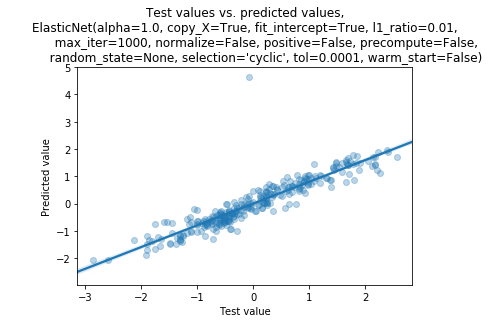

In [637]:
comp_train_test(elastic_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

These test stats barely budged, compared to the original test stats above.

In [638]:
yscale_predicted = elastic_scl.predict(X_scaled)

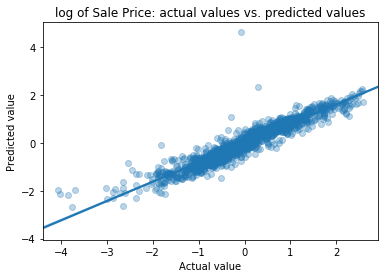

In [639]:
ax = sns.regplot(Y_scaled,yscale_predicted,scatter_kws={'alpha':0.3})
ax.set(xlabel='Actual value', ylabel='Predicted value',
       title='log of Sale Price: actual values vs. predicted values')
plt.show()

In [640]:
print("R-squared of the model on the full dataset is: {}".format(elastic_scl.score(X_scaled, Y_scaled)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_scaled, yscale_predicted)))
print("Mean squared error of the prediction is: {}".format(mse(Y_scaled, yscale_predicted)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_scaled, yscale_predicted)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_scaled - yscale_predicted) / Y_scaled)) * 100))

R-squared of the model on the full dataset is: 0.8814723302275509
Mean absolute error of the prediction is: 0.22844575649900983
Mean squared error of the prediction is: 0.11852766977244916
Root mean squared error of the prediction is: 0.3442784770682727
Mean absolute percentage error of the prediction is: 125.41141925396337


That the MAPE is over 100% concerns me...but the R-squared value looks great, and the other values (MAE, MSE, RMSE) seem low.

__One thing I am curious about is whether we'd want to run through all of the other training/testing steps again--this particular ElasticNet model was best for the data I started with, but now that I've added three new (hopefully significant?) features based on external sources, is it still the best?__